In [46]:
#https://ieeexplore.ieee.org/document/9025572
#https://ieeexplore.ieee.org/document/8265477
#https://ieeexplore.ieee.org/search/searchresult.jsp?newsearch=true&queryText=outfit%20recommend
#https://ieeexplore.ieee.org/document/9804781
#https://developers.google.com/public-data/docs/canonical/countries_csv
#https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state
#https://stackoverflow.com/questions/65244102/how-to-get-latitude-and-longitude-from-an-address-scraping-google-maps
#https://geokeo.com/database/county/gb/
#https://simplemaps.com/data/gb-cities
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8628399/
#https://caffeinedev.medium.com/how-to-install-tensorflow-on-m1-mac-8e9b91d93706 tenserflow

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 15 19:50:42 2024

@author: shrutipatkar
"""
import warnings
import pandas as pd
import numpy as np
import difflib
import pycountry
from geopy.geocoders import Nominatim
import re
from datetime import datetime
from matplotlib import colors
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
import re
from colour import Color
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split

In [47]:
warnings.filterwarnings('ignore')

In [48]:
spell = SpellChecker()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutipatkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
# Function to find the best match and its confidence
def get_best_match_with_confidence(country):
    country = country.replace("City", "")
    if "Englan" in country:
        country = "United Kingdom"
    if "rkiye" in country and country.startswith("T"):
        country = "Turkey"
    try:
        try:
            country = alpha_2_mapping[country]
        except:
            pass
        matches = difflib.get_close_matches(country, country_names, n=1)
        if matches:
            best_match = matches[0]
            confidence = difflib.SequenceMatcher(None, country, best_match).ratio()
            if confidence >= 0.80:
                return best_match, confidence
            else:
                print(country)
                return country, 0            
        else:
            print(country)
            return country, 0
    except:
        print(country)
        return country, 0
    
# Function to convert country names to numbers
#def convert_country_to_number(country):
#    return country_mapping.get(country, None) 

def calculateAge(birthDate):
    try:
        today = datetime.today()
        age = today.year - birthDate.year -((today.month, today.day) <(birthDate.month, birthDate.day))    
    except:
        return None
    return age

# Function to normalize sizes like "4XL" into "XXXXL" and include "XS"
def normalize_size_large(size):
    match = re.match(r"(\d+)(XL)", size.upper().strip())
    match_2 = re.match(r"(\d+)(XS)", size.upper().strip())
    if match:
        number = int(match.group(1))
        return "X" * number + "L"
    elif match_2:
        number = int(match_2.group(1))
        return "X" * number + "S"
    else:
        return size.strip()
    
def normalize_size_small(size):
    match = re.match(r"(\d+)(XS)", size.strip())
    if match:
        number = int(match.group(1))
        return "X" * number + "L"
    else:
        return size.strip()
    
# Function to convert clothes sizes to numerical values
def convert_size_to_numbers(sizes):
    if pd.isna(sizes):
        return 0
    sizes = sizes.split(',')
    numeric_sizes = [size_mapping[size.strip()] for size in sizes if size.strip() in size_mapping]
    return numeric_sizes if numeric_sizes else None

# Function to convert personality types to numerical values
def convert_personality_to_number(personality):
    for key in personality_mapping:
        if key == personality:
            return personality_mapping[key]
    return 4

def check_color(color_name):
    try:
        Color(color_name)
        return True
    except ValueError:
        return False

def split_by_capital(s):
    if len(s.split(" ")) == 1 and s[0].isupper() and s[1].islower():
        # Split the string at each point a new capital letter starts, except for the very beginning of the string
        parts = re.findall('[A-Z][^A-Z]*', s)
        return parts
    else:
        return s.split(" ")

#def validate_colors(parts):
#    valid_colors = []
#    # Check each part to see if it's a valid color
#    for part in parts:
#        if check_color(part):
#            valid_colors.append(part)
#    return valid_colors

def custom_to_rgba(name):
    try:
        int32_values = []
        color_name_2=[]
        # Split the string based on capital letters
        color_name = split_by_capital(name)
        color_name  = [i for i in color_name if len(i)>2]
        for i in color_name:
            i = i.rstrip('s')
            i = i.rstrip('ish')
            if spell.correction(i.lower()) is None:
                color_name_2.append(i.lower())
            else:
                color_name_2.append(spell.correction(i.lower()))
                color_name_2.append(i.lower().strip())
        color_names_3  = [i for i in color_name_2 if check_color(i)]
        if len(color_names_3) <= 0:
            color_names_3 = color_name_2
        color_names_3 = list(set(color_names_3))
        for color_name_3 in color_names_3:
            color_name_3 = color_name_3.lower().replace(" ", "").strip()
            if color_name_3.startswith("b") and color_name_3.endswith("ck"):
                color_name_3 = "black"
                int32_values.append(color_name_3)
            elif color_name_3.startswith("whit"):
                color_name_3 = "white"
                int32_values.append(color_name_3)
            elif color_name_3.startswith("bl") and color_name_3.endswith("ck") == False:
                color_name_3 = "blue"
                int32_values.append(color_name_3)
            elif color_name_3.startswith("voil"):
                color_name_3 = "violet"
                int32_values.append(color_name_3)
            elif color_name_3.startswith("ros") or color_name_3.endswith("ink"):
                color_name_3 = "pink"
                int32_values.append(color_name_3)
            elif color_name_3.endswith("ojo") or color_name_3.startswith("verm"):
                color_name_3 = "red" 
                int32_values.append(color_name_3)
            elif color_name_3.startswith("verd"):
                color_name_3 = "green"
                int32_values.append(color_name_3)
            elif color_name_3.startswith("azu"):
                color_name_3 = "blue"
                int32_values.append(color_name_3)
            elif color_name_3.startswith("negr") or color_name_3.startswith("ne"):
                color_name_3 = "black"
                int32_values.append(color_name_3)
            elif color_name_3.startswith("bian"):
                color_name_3 = "white"
                int32_values.append(color_name_3)
            elif color_name_3.startswith("saf") and color_name_3.endswith("on"):
                color_name_3 = "orange"
                int32_values.append(color_name_3)
            elif "denim" in color_name_3 or "jean" in color_name_3:
                color_name_3 = "blue"
                int32_values.append(color_name_3)
            elif color_name_3 == "mauve":
                int32_values.append(color_name_3)
            elif color_name_3.startswith("lil") :
                int32_values.append(color_name_3)
            elif color_name_3.startswith("peac"):
                int32_values.append(color_name_3)
            elif color_name_3 == "cream":
                int32_values.append(color_name_3) 
            elif (color_name_3.startswith("b") and color_name_3.endswith("ge")) or color_name_3.startswith("offw"):
                int32_values.append(color_name_3)
            elif color_name_3 == "burgundy":
                int32_values.append(color_name_3)
            elif color_name_3 == "nude":
                int32_values.append(color_name_3)
            elif color_name_3 == "khaki" or color_name_3 == "kakhi" or color_name_3 == "kaki" or color_name_3 == "olive":
                int32_values.append(color_name_3)
            elif color_name_3.startswith("sand") or color_name_3 == "mustard":
                int32_values.append(color_name_3)
        if len(int32_values) < 1:
            raise Exception
        else:
            return list(set(int32_values))
    except Exception:
        int32_values.append(np.nan)
        return int32_values  # Default to transparent if invalid

def remove_bracketed_text(text):
    if pd.isna(text):
        return text
    return re.sub(r'\(.*?\)', '', text).strip()

# Function to remove stop words
def remove_stop_words(text):
    if pd.isna(text):
        return text
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def replace_clothing_type(text):
    text = text.lower()  # Convert to lowercase for consistent matching
    if 'street' in text:
        return 'streetwear'
    elif 'sport' in text:
        return 'sportswear'
    elif 'dress' in text or 'saree' in text or 'sadi' in text or 'traditional' in text or 'religi' in text:
        return 'traditional'
    elif 'offic' in text or 'formal' in text:
        return 'formal'
    elif 'athleisure' in text:
        return 'casual'
    elif 'basic' in text or 'casual' in text or 'smart' in text:
        return 'casual'
    elif 'party' in text:
        return 'partywear'
    elif text in allowed_types:
        return text
    else:
        return "other"
    
# Function to convert clothing types to numbers
#def convert_clothing_type_to_number(clothing_type):
#    if ',' in clothing_type:
#        return ', '.join(str(clothing_type_mapping[ct.strip()]) for ct in clothing_type.split(','))
#    else:
#        return clothing_type_mapping.get(clothing_type, None)
    
def Preferred_Bottoms(text):
    clothing_items = ["skirt","sweatpant", "sweatshorts","koreanpants","formalpants","chinos","straightpants",
                      "joggers","leggings", "all"]
    text = str(text)
    if text in clothing_items:
        return text
    elif 'skirt' in text:
        return 'skirt'
    elif 'sweatpant' in text or 'sweat' in text:
        return 'sweatpants'
    elif 'dress' in text or 'saree' in text or 'sadi' in text or 'traditional' in text or 'religi' in text or "salwar" in text or "burkah" in text:
        return 'traditional'
    elif 'offic' in text or 'formal' in text:
        return 'formalpants'
    elif 'korea' in text:
        return 'koreanpants'
    elif 'chino' in text:
        return 'chinos'
    elif 'straightpant' in text or "denim" in text or "pant" in text or "short" in text:
        return 'straightpants'
    elif 'jogger' in text:
        return 'joggers'
    elif "legging" in text:
        return "leggings"
    elif text == "nan":
        return "nan"
    else:
        return "other"

def Preferred_Upperwear(text):
    text = text.replace(" ", "")
    if "sweat" in "text":
        return "sweatshirt"
    elif 'tshirt' in text:
        return 'tshirt'
    elif 'shirt' in text:
        return 'shirt'
    elif "tee" in text:
        return "tshirt"
    elif "top" in text:
        return "top"
    elif "sadi" in text:
        return "blouse"
    else:
        return text
def handle_output_columns(df, column_name): 
    print(column_name)
    df[column_name] = df[column_name].apply(lambda x:str(x).lower().replace("-", " ").replace("vegan", "").strip())
    df[column_name] = df[column_name].str.replace(r'\[.*?\]|\(.*?\)', '', regex=True)
    df[column_name] = df[column_name].apply(lambda x: 'all' if 'depend' in x or ' any' in x 
                                            or x.startswith("any") or ' every' in x or x.startswith("every") 
                                            or ' all ' in x or x.startswith("all ")
                                            or 'nopreference' in x.replace(" ", "")
                                            or 'noidea' in x.replace(" ", "")
                                            or 'different' in x.replace(" ", "")
                                            or 'donthave' in x.replace(" ", "").replace("'", "")
                                            or 'doesntmatter' in x.replace(" ", "").replace("'", "")
                                            else x)
    df[column_name] = df[column_name].apply(lambda x: 'denim' if 'jean' in x.replace(" ", "") else x)
    df[column_name] = df[column_name].apply(lambda x: 'nan' if 'none' in x.replace(" ", "") else x)
    df[column_name] = df[column_name].apply(lambda x: 'box' if 'square' in x or 'box' in x else x)
    df[column_name] = df[column_name].apply(lambda x: 'round' if 'crew' in x else x)
    df[column_name] = df[column_name].str.split(",")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split(" and ")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split(" or ")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split("/")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split("&")
    df = df.explode(column_name)
    if column_name == "Preferred_Bottoms":
        df[column_name] = df[column_name].apply(Preferred_Bottoms)
        df[column_name] = df.apply(lambda x: Preferred_Bottoms(x["Bottoms_Other_Details"]) 
                              if x[column_name] == "other" or x[column_name] == "nan" else x[column_name],axis=1)
    elif column_name == "Bottoms_Length":
        df[column_name] = df[column_name].apply(lambda x: ' '.join(x.split()[:2]))
    elif column_name == "Bottoms_Fitting" or column_name == "Single_Piece_Fitting":
        df[column_name] = df[column_name].apply(lambda x: x.replace(" ", "").replace("fit", ""))
    elif column_name == "Preferred_Upperwear":
        df[column_name] = df[column_name].apply(Preferred_Upperwear)
        df[column_name] = df.apply(lambda x: Preferred_Bottoms(x["Upperwear_Other_Details"]) 
                              if x[column_name] == "other" or x[column_name] == "nan" else x[column_name],axis=1)
    elif column_name == "Upperwear_Length" or column_name == "Single_Piece_Length":
        df[column_name] = df[column_name].apply(lambda x: 'regular' if ('no' in x and "long" in x) else x)
        df[column_name] = df[column_name].apply(lambda x: 'regular' if ('medium' in x) else x)
        df[column_name] = df[column_name].apply(lambda x: x.replace("er ", " "))
        df[column_name] = df[column_name].apply(lambda x: ' '.join(x.split()[:1]))
    elif column_name == "Upperwear_Sleeve_Type" or column_name == "Single_Piece_Sleeves":
        df[column_name] = df[column_name].apply(lambda x: x.replace("sleeves", "").strip())
        df[column_name] = df[column_name].apply(lambda x: 'full' if 'roll' in x else x)
        df[column_name] = df[column_name].apply(lambda x: 'full' if 'fold' in x else x)  
    if column_name.find('Color') == -1:
        df[column_name] = df[column_name].apply(lambda x:str(x).lower().replace(" ", "").strip())  
        # Create a mapping from unique values to numerical values
        preferred_bottoms_mapping = {bottom: idx + 1 for idx, bottom in enumerate(df[column_name].unique())}
        preferred_bottoms_mapping[np.nan] = 0 
        preferred_bottoms_mapping["nan"] = 0
        # Save each mapping to a JSON file
        with open(column_name+'.json', 'w') as f:
            json.dump(preferred_bottoms_mapping, f)
        df[column_name] = df[column_name].map(preferred_bottoms_mapping)
    else:
        df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
        df[column_name] = df[column_name].apply(custom_to_rgba)
        df = df.explode(column_name)
        #df[[column_name+'_r', column_name+'_g', column_name+'_b', column_name+'_a']] = pd.DataFrame(df[column_name].tolist(), index=df.index)
    return df


In [5]:
df = pd.read_excel("dataset.xlsx")



In [10]:
df.describe()

Weight_kg    Height_cm
count  2108.000000  2108.000000
mean     73.342987   150.603869
std      20.119437    51.818754
min       0.000000     1.400000
25%      60.000000   157.000000
50%      70.000000   167.000000
75%      82.000000   176.000000
max     200.000000   250.000000

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2108 entries, 1922 to 1520
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country_of_Birth              2108 non-null   object 
 1   Country_of_Residence          2108 non-null   object 
 2   Birthdate                     2108 non-null   object 
 3   Gender                        2108 non-null   object 
 4   Weight_kg                     2108 non-null   float64
 5   Height_cm                     2108 non-null   float64
 6   Preferred_Clothing_Type       2099 non-null   object 
 7   Personality                   2108 non-null   object 
 8   Clothing_Size                 2108 non-null   object 
 9   Favourite_Color               2108 non-null   object 
 10  Color_Boost_Confidence        2108 non-null   object 
 11  Best_Color_Confidence         389 non-null    object 
 12  Preferred_Bottoms             1625 non-null   object 
 13  

In [12]:
# Check for missing values
print(df.isnull().sum())

# You can fill missing values using a specified value or method
# For example, filling missing values with the median
df['Weight_kg'].fillna(df['Weight_kg'].median(), inplace=True)
df['Height_cm'].fillna(df['Height_cm'].median(), inplace=True)

Country_of_Birth                   0
Country_of_Residence               0
Birthdate                          0
Gender                             0
Weight_kg                          0
Height_cm                          0
Preferred_Clothing_Type            9
Personality                        0
Clothing_Size                      0
Favourite_Color                    0
Color_Boost_Confidence             0
Best_Color_Confidence           1719
Preferred_Bottoms                483
Bottoms_Material                 483
Bottoms_Length                   483
Bottoms_Fitting                  483
Bottoms_Color                    484
Bottoms_Other_Details           1196
Preferred_Upperwear              483
Upperwear_Material               483
Upperwear_Length                 483
Upperwear_Neckline               483
Upperwear_Sleeve_Type            483
Upperwear_Pattern                483
Upperwear_Print_Type            1796
Upperwear_Color                  485
Upperwear_Other_Details         1265
F

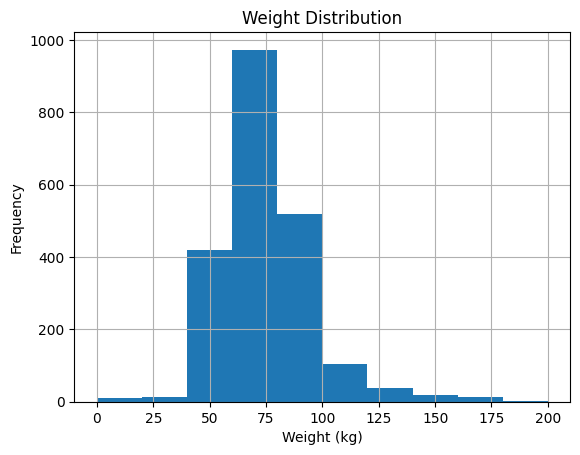

In [13]:
import matplotlib.pyplot as plt

# Histogram for weight distribution
df['Weight_kg'].hist()
plt.title('Weight Distribution')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.show()



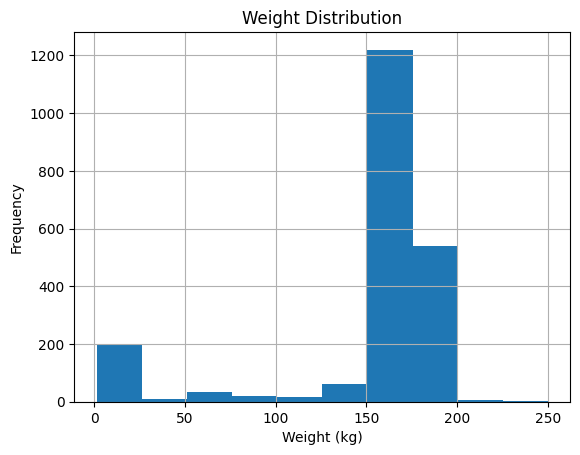

In [14]:
import matplotlib.pyplot as plt

# Histogram for weight distribution
df['Height_cm'].hist()
plt.title('Weight Distribution')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.show()

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame already loaded with data

# Define a function to plot bar charts for categorical data, focusing only on the top 5 categories
def plot_bar_chart(data, title, xlabel, ylabel):
    top_data = data.value_counts().nlargest(5)  # Selects the top 5 most frequent categories
    top_data.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Define a function to plot pie charts for categorical data, also focusing only on the top 5 categories
def plot_pie_chart(data, title):
    top_data = data.value_counts().nlargest(5)  # Selects the top 5 most frequent categories
    top_data.plot(kind='pie', autopct='%1.1f%%')
    plt.title(title)
    plt.ylabel('')  # Hide the y-label as it's usually not needed for pie charts
    plt.show()

# Analyze Fit Preferences
plot_bar_chart(df['Bottoms_Fitting'], 'Fit Preferences', 'Fit Type', 'Count')

# Analyze Length Preferences
#plot_bar_chart(df['Bottoms_Length'], 'Length Preferences', 'Length Type', 'Count')

# Analyze Type of Wear
#plot_bar_chart(df['Preferred_Clothing'], 'Type of Wear Preferences', 'Clothing Type', 'Count')

# Analyze Neckline Preferences
#plot_pie_chart(df['Upperwear_Neckline'], 'Neckline Preferences')

# Analyze Sleeve Preferences
#plot_bar_chart(df['Upperwear_Sleeve_Type'], 'Sleeve Preferences', 'Sleeve Type', 'Count')

# Analyze Pattern Preferences
#plot_bar_chart(df['Upperwear_Pattern'], 'Pattern Preferences', 'Pattern Type', 'Count')


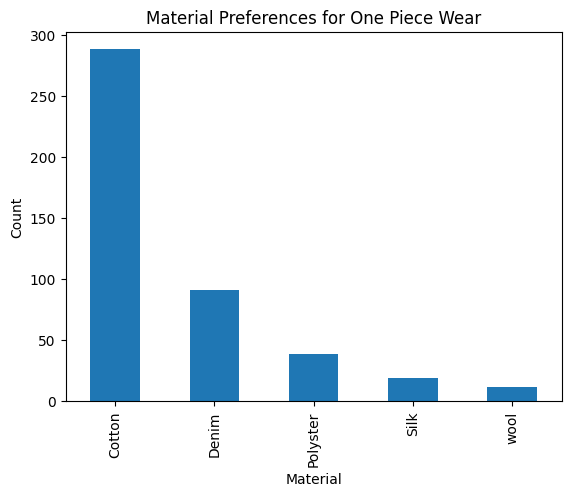

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame already loaded with data

# Filter to get data related to 'One Piece Wear'
one_piece_df = df[df['Preferred_Clothing'] == 'Single Piece Wear']

# Define a function to plot bar charts for categorical data, focusing only on the top 5 categories
def plot_bar_chart(data, title, xlabel, ylabel):
    if not data.empty:
        top_data = data.value_counts().nlargest(5)  # Selects the top 5 most frequent categories
        if not top_data.empty:
            top_data.plot(kind='bar')
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
        else:
            print(f"No data available to plot for {title}")
    else:
        print(f"No entries to plot for {xlabel}")
    plt.show()

# Define a function to plot pie charts for categorical data, also focusing only on the top 5 categories
def plot_pie_chart(data, title):
    if not data.empty:
        top_data = data.value_counts().nlargest(5)  # Selects the top 5 most frequent categories
        if not top_data.empty:
            top_data.plot(kind='pie', autopct='%1.1f%%')
            plt.title(title)
            plt.ylabel('')  # Hide the y-label as it's usually not needed for pie charts
        else:
            print(f"No data available to plot for {title}")
    else:
        print(f"No entries to plot for {title}")
    plt.show()

# Specific analyses for One Piece Wear
# Example: Material Preferences for One Piece Wear
plot_bar_chart(one_piece_df['Single_Piece_Material'], 'Material Preferences for One Piece Wear', 'Material', 'Count')

# Example: Pattern Preferences for One Piece Wear
#plot_bar_chart(one_piece_df['Single_Piece_Pattern'], 'Pattern Preferences for One Piece Wear', 'Pattern', 'Count')

# Example: Sleeve Preferences for One Piece Wear
#plot_bar_chart(one_piece_df['Single_Piece_Sleeves'], 'Sleeve Preferences for One Piece Wear', 'Sleeve Type', 'Count')

# Example: Length Preferences for One Piece Wear
#plot_bar_chart(one_piece_df['Single_Piece_Length'], 'Length Preferences for One Piece Wear', 'Length', 'Count')

# Example: Color Preferences for One Piece Wear
#plot_pie_chart(one_piece_df['Single_Piece_Color'], 'Color Preferences for One Piece Wear')


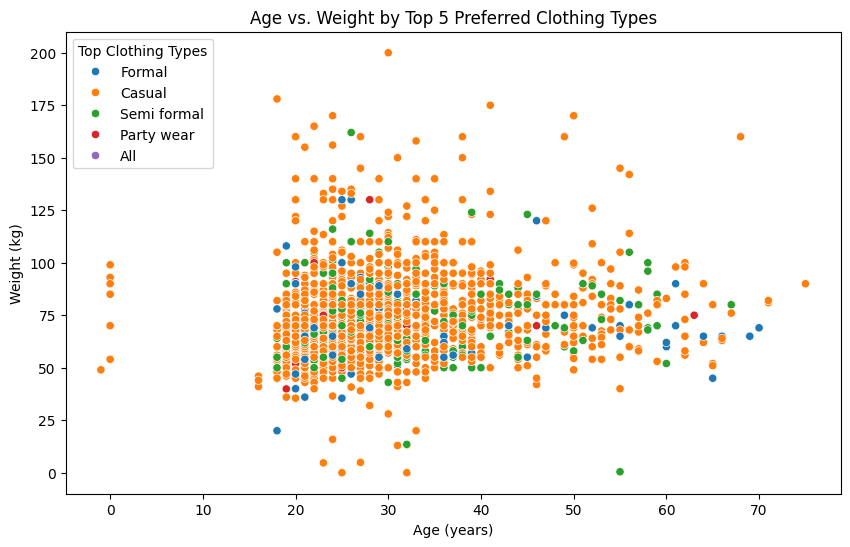

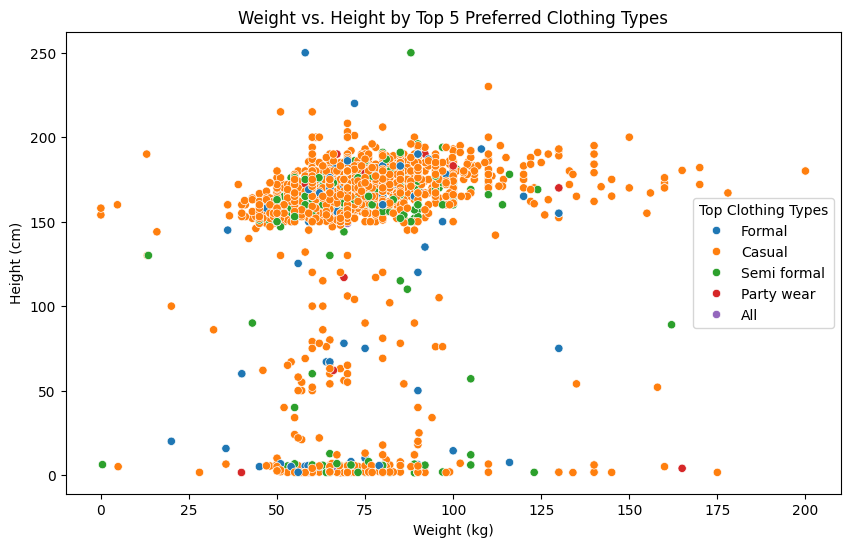

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data (assuming it's already loaded into the DataFrame 'df')
# Convert 'Birthdate' to datetime format and calculate 'Age'
df['Birthdate'] = pd.to_datetime(df['Birthdate'], errors='coerce')
df['Age'] = (pd.Timestamp.now() - df['Birthdate']).dt.days // 365

# Ensure 'Weight_kg' and 'Height_cm' are numeric
df['Weight_kg'] = pd.to_numeric(df['Weight_kg'], errors='coerce')
df['Height_cm'] = pd.to_numeric(df['Height_cm'], errors='coerce')

# Drop rows with missing values in these columns to ensure accurate plot results
df.dropna(subset=['Age', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type'], inplace=True)

# Identify the top 5 most frequent clothing types
top_clothing_types = df['Preferred_Clothing_Type'].value_counts().nlargest(5).index

# Filter the DataFrame to include only the top 5 clothing types
top_df = df[df['Preferred_Clothing_Type'].isin(top_clothing_types)]

# Scatter Plot: Age vs. Weight by Top 5 Preferred Clothing Types
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Weight_kg', hue='Preferred_Clothing_Type', data=top_df)
plt.title('Age vs. Weight by Top 5 Preferred Clothing Types')
plt.xlabel('Age (years)')
plt.ylabel('Weight (kg)')
plt.legend(title='Top Clothing Types')
plt.show()

# Scatter Plot: Age vs. Height by Top 5 Preferred Clothing Types
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Height_cm', hue='Preferred_Clothing_Type', data=top_df)
plt.title('Age vs. Height by Top 5 Preferred Clothing Types')
plt.xlabel('Age (years)')
plt.ylabel('Height (cm)')
plt.legend(title='Top Clothing Types')
plt.show()

# Scatter Plot: Weight vs. Height by Top 5 Preferred Clothing Types
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Weight_kg', y='Height_cm', hue='Preferred_Clothing_Type', data=top_df)
plt.title('Weight vs. Height by Top 5 Preferred Clothing Types')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')
plt.legend(title='Top Clothing Types')
plt.show()


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the DataFrame 'df' is already loaded and includes the new column names you mentioned

# Function to plot bar charts for categorical data
def plot_bar_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    color_count = data.value_counts().nlargest(10)  # Taking the top 10 most common entries
    sns.barplot(x=color_count.index, y=color_count.values, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Rotate labels to prevent overlap
    plt.show()

x = df[df['Best_Color_Confidence']!=0]
# Color that boosts confidence
plot_bar_chart(x['Best_Color_Confidence'], 'Colors That Boost Confidence', 'Color', 'Frequency')
x = df[df['Favourite_Color']!=0]
# Color that boosts confidence
#plot_bar_chart(x['Favourite_Color'], 'Favourite Color', 'Color', 'Frequency')
x = df[df['Bottoms_Color']!=0]
# Colors chosen for bottoms
#plot_bar_chart(x['Bottoms_Color'], 'Preferred Colors for Bottom Wear', 'Color', 'Frequency')
x = df[df['Bottoms_Color']!=0]
# Colors chosen for upper wear
#plot_bar_chart(x['Upperwear_Color'], 'Preferred Colors for Upper Wear', 'Color', 'Frequency')
x = df[df['Single_Piece_Color']!=0]
# Colors chosen for single piece wear
#plot_bar_chart(x['Single_Piece_Color'], 'Preferred Colors for Single Piece Wear', 'Color', 'Frequency')


In [54]:
df

Gender  Weight_kg  Height_cm  Preferred_Clothing_Type  Personality  \
0          3       50.0      162.0                      3.0            1   
0          3       50.0      162.0                      3.0            1   
0          3       50.0      162.0                      3.0            1   
1          3       50.0      162.0                      3.0            1   
1          3       50.0      162.0                      3.0            1   
...      ...        ...        ...                      ...          ...   
5982       3       60.0      170.0                      2.0            2   
5982       3       60.0      170.0                      2.0            2   
5982       3       60.0      170.0                      2.0            2   
5982       3       60.0      170.0                      2.0            2   
5982       3       60.0      170.0                      2.0            2   

      Clothing_Size  Preferred_Clothing Favourite_Color Best_Color_Confidence  \
0                 5                   0           black                 black   
0                 6                   0           black                 black   
0                 7                   0           black                 black   
1                 5                   0           black                 black   
1                 6                   0           black                 black   
...             ...                 ...             ...                   ...   
5982              8                   1           beige                 beige   
5982              9                   1           beige                 beige   
5982              9                   1           beige                 beige   
5982              9                   1           beige                 beige   
5982              9                   1           beige                 beige   

                             Preferred_Bottoms  ... Single_Piece_Length  \
0                                            0  ...         Full length   
0                                            0  ...         Full length   
0                                            0  ...         Full length   
1                                            0  ...         Full length   
1                                            0  ...         Full length   
...                                        ...  ...                 ...   
5982  Straight pants(Jeans, cotton pants, etc)  ...                   0   
5982  Straight pants(Jeans, cotton pants, etc)  ...                   0   
5982  Straight pants(Jeans, cotton pants, etc)  ...                   0   
5982  Straight pants(Jeans, cotton pants, etc)  ...                   0   
5982  Straight pants(Jeans, cotton pants, etc)  ...                   0   

     Single_Piece_Sleeves Single_Piece_Neckline Single_Piece_Pattern  \
0                   strap           turtle neck          solid color   
0                   strap           turtle neck          solid color   
0                   strap           turtle neck          solid color   
1                   strap           turtle neck                    0   
1                   strap           turtle neck                    0   
...                   ...                   ...                  ...   
5982                    0                     0                    0   
5982                    0                     0                    0   
5982                    0                     0                    0   
5982                    0                     0                    0   
5982                    0                     0                    0   

     Single_Piece_Color birthplace_lat birthplace_lon   resi_lat   resi_lon  \
0                 black     -30.559482      22.937506 -30.559482  22.937506   
0                 black     -30.559482      22.937506 -30.559482  22.937506   
0                 black     -30.559482      22.937506 -30.559482  22.937506   
1                 black     -30.559482

In [70]:
df = pd.read_excel("dataset.xlsx")
country_map = pd.read_excel("country_to_lat_long.xlsx")

# Assuming 'Preferred_Clothing' is the target variable
X = df.drop('What type of clothing you like to wear', axis=1)  # Features
y = df['What type of clothing you like to wear']  # Target

# Split the data into remaining data and evaluation sets
X_remaining, X_eval, y_remaining, y_eval = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

# Merge back X_eval and y_eval into a single DataFrame
eval_df = pd.concat([X_eval, y_eval], axis=1)

# Save this evaluation DataFrame to an Excel file
eval_df.to_excel("evaluation_data.xlsx", index=False)

# Merge back X_eval and y_eval into a single DataFrame
df = pd.concat([X_remaining, y_remaining], axis=1)

# dictionary to map the current column names to new names
new_column_names = {'Country of Birth': 'Country_of_Birth',
    'Country of Residence': 'Country_of_Residence',
    'Birthdate': 'Birthdate',
    'Gender': 'Gender',
    'Approximate weight in kilogram': 'Weight_kg',
    'Approximate height in centimetre': 'Height_cm',
    'What type of clothes you prefer to wear': 'Preferred_Clothing_Type',
    'How do you define yourself': 'Personality',
    'Size of clothes you wear': 'Clothing_Size',
    'What is your favourite color.': 'Favourite_Color',
    'Do you think this color looks best on you and boost your confidence?': 'Color_Boost_Confidence',
    'Which color do you think looks best on you and makes you feel confident?': 'Best_Color_Confidence',
    'What type of clothing you like to wear': 'Preferred_Clothing',
    'What is your preferred bottoms': 'Preferred_Bottoms',
    'Material preferred for your bottoms?': 'Bottoms_Material',
    'Length of bottoms you prefer?': 'Bottoms_Length',
    'How do you prefer the fitting of your bottoms?': 'Bottoms_Fitting',
    'Which color of bottoms would you prefer. (Please mention two colours)': 'Bottoms_Color',
    'Any other specific detail about the bottoms you will like to mention?': 'Bottoms_Other_Details',
    'What is your prefered upperwear on the selected bottoms?': 'Preferred_Upperwear',
    'What material you will prefer for the upperwear?': 'Upperwear_Material',
    'What length of upperwear would you choose?': 'Upperwear_Length',
    'What is your prefered neckline for them?': 'Upperwear_Neckline',
    'What is your preferred sleeve type?': 'Upperwear_Sleeve_Type',
    'What pattern will you like on you upperwear?': 'Upperwear_Pattern',
    'which type of print': 'Upperwear_Print_Type',
    'What is your preferred color for the selected upperwear to go on the selected bottoms?Please select two)': 'Upperwear_Color',
    'Any other specific detail about the upper wear?': 'Upperwear_Other_Details',
    'Favourite type of single piece wear': 'Favourite_Single_Piece',
    'What is your preferred material?': 'Single_Piece_Material',
    'How do you prefer the fitting?': 'Single_Piece_Fitting',
    'What is your preferred length?': 'Single_Piece_Length',
    'How will you prefer your sleeves?': 'Single_Piece_Sleeves',
    'How would you prefer your neckline?': 'Single_Piece_Neckline',
    'What is your preferred pattern?': 'Single_Piece_Pattern',
    'which type of print.1': 'Single_Piece_Print_Type',
    'Would you prefer the colour which you have mentioned in previous section?': 'Single_Piece_Preferred_Color',
    'What color would you like to choose for you single piece wear': 'Single_Piece_Color',
    'Any other specific detail about the clothing?': 'Clothing_Other_Details',
    'Do you like to wear outer layer on top?': 'Outer_Layer_Preference',
    'What type of outer layer you prefer to wear': 'Preferred_Outer_Layer',
    'What is your preferred material?.1': 'Outer_Layer_Material',
    'How do you prefer the fitting?.1': 'Outer_Layer_Fitting',
    'What is your preferred length?.1': 'Outer_Layer_Length',
    'How will you prefer your sleeves?.1': 'Outer_Layer_Sleeves',
    'How would you prefer your neckline?.1': 'Outer_Layer_Neckline',
    'Type of closing ': 'Outer_Layer_Closing_Type',
    'What color would you like to choose?': 'Outer_Layer_Color',
    'What is your preferred pattern?.1': 'Outer_Layer_Pattern',
    'which type of print.2': 'Outer_Layer_Print_Type',
    'Any other specific detail about the outer layer?': 'Outer_Layer_Other_Details'}

# Define a mapping from size to a numerical value using the provided values
size_mapping = {'XXXXXS': 1, 'XXXXS': 2, 'XXXS': 3, 'XXS': 4, 'XS': 5, 'S': 6, 'M': 7, 'L': 8,
                'XL': 9, 'XXL': 10, 'XXXL': 11, 'XXXXL': 12, 'XXXXXL': 13}

personality_mapping = {'Introvert (Are you shy, reticent person?)': 1,
    'Ambivert (Are you able to balance between extrovert and introvert?)': 2,
    'Extrovert (Are you outgoing, socially confident?)': 3,}

allowed_types = ['semiformal', 'casual', 'formal', 'partywear', 'traditional', 'sportswear', 'streetwear']

invalid_colors = []

mapping_pattern = {}  

# Define the mapping for the 'Preferred_clothing' column
preferred_clothing_mapping = {'Single Piece Wear': 0, 'Two Piece Wear': 1}

columns_to_process = [ 'Bottoms_Color',  'Upperwear_Color',  'Single_Piece_Color']

# Rename the columns in the DataFrame
df.rename(columns=new_column_names, inplace=True)
df.drop(columns=["Timestamp", "Consent Form:\nI have read the description and accompanying Information Sheet relating to the project on Personality Based Outfit Selection System and understand that participation is entirely voluntary and that I have the right to withdraw from the project any time, and that this will be without detriment. This application has been reviewed by the University Research Ethics Committee and has been given a favourable ethical opinion for conduct.", "Please read the document carefully and proceed with th consent form."], inplace=True)

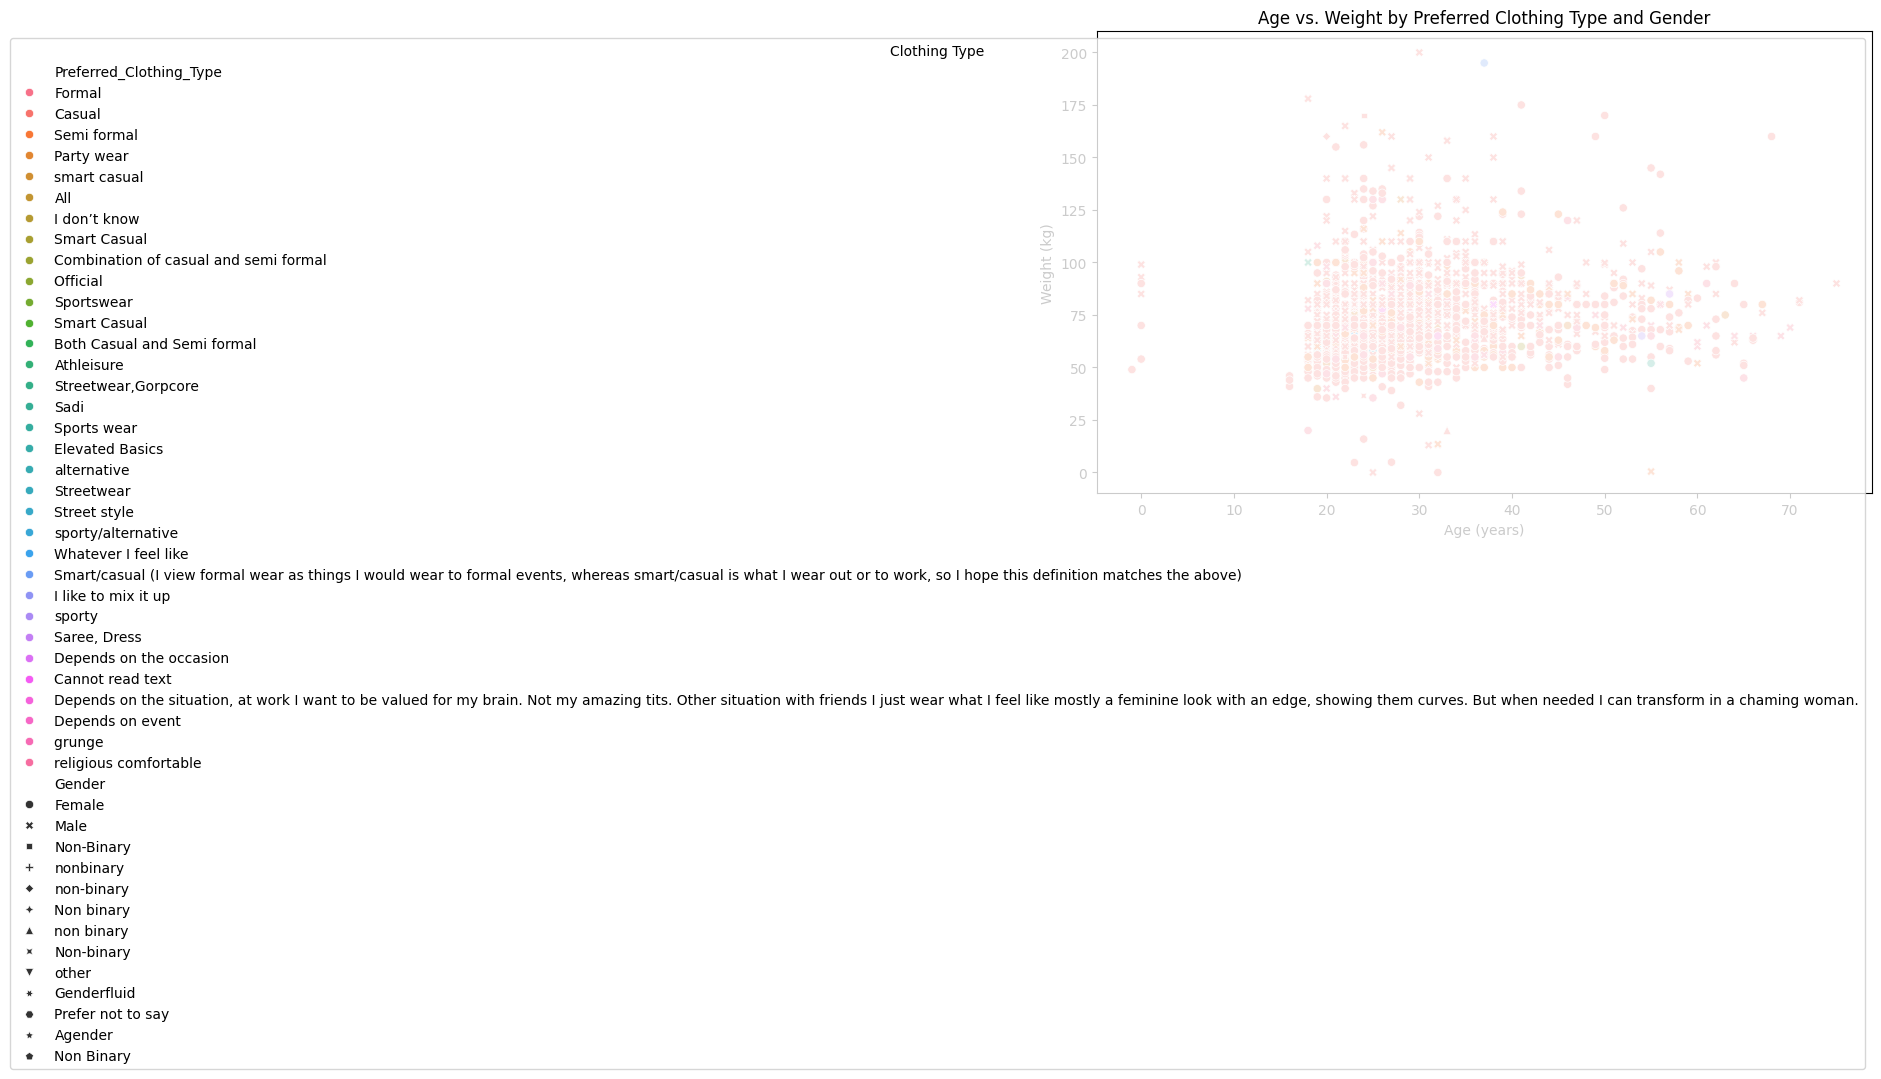

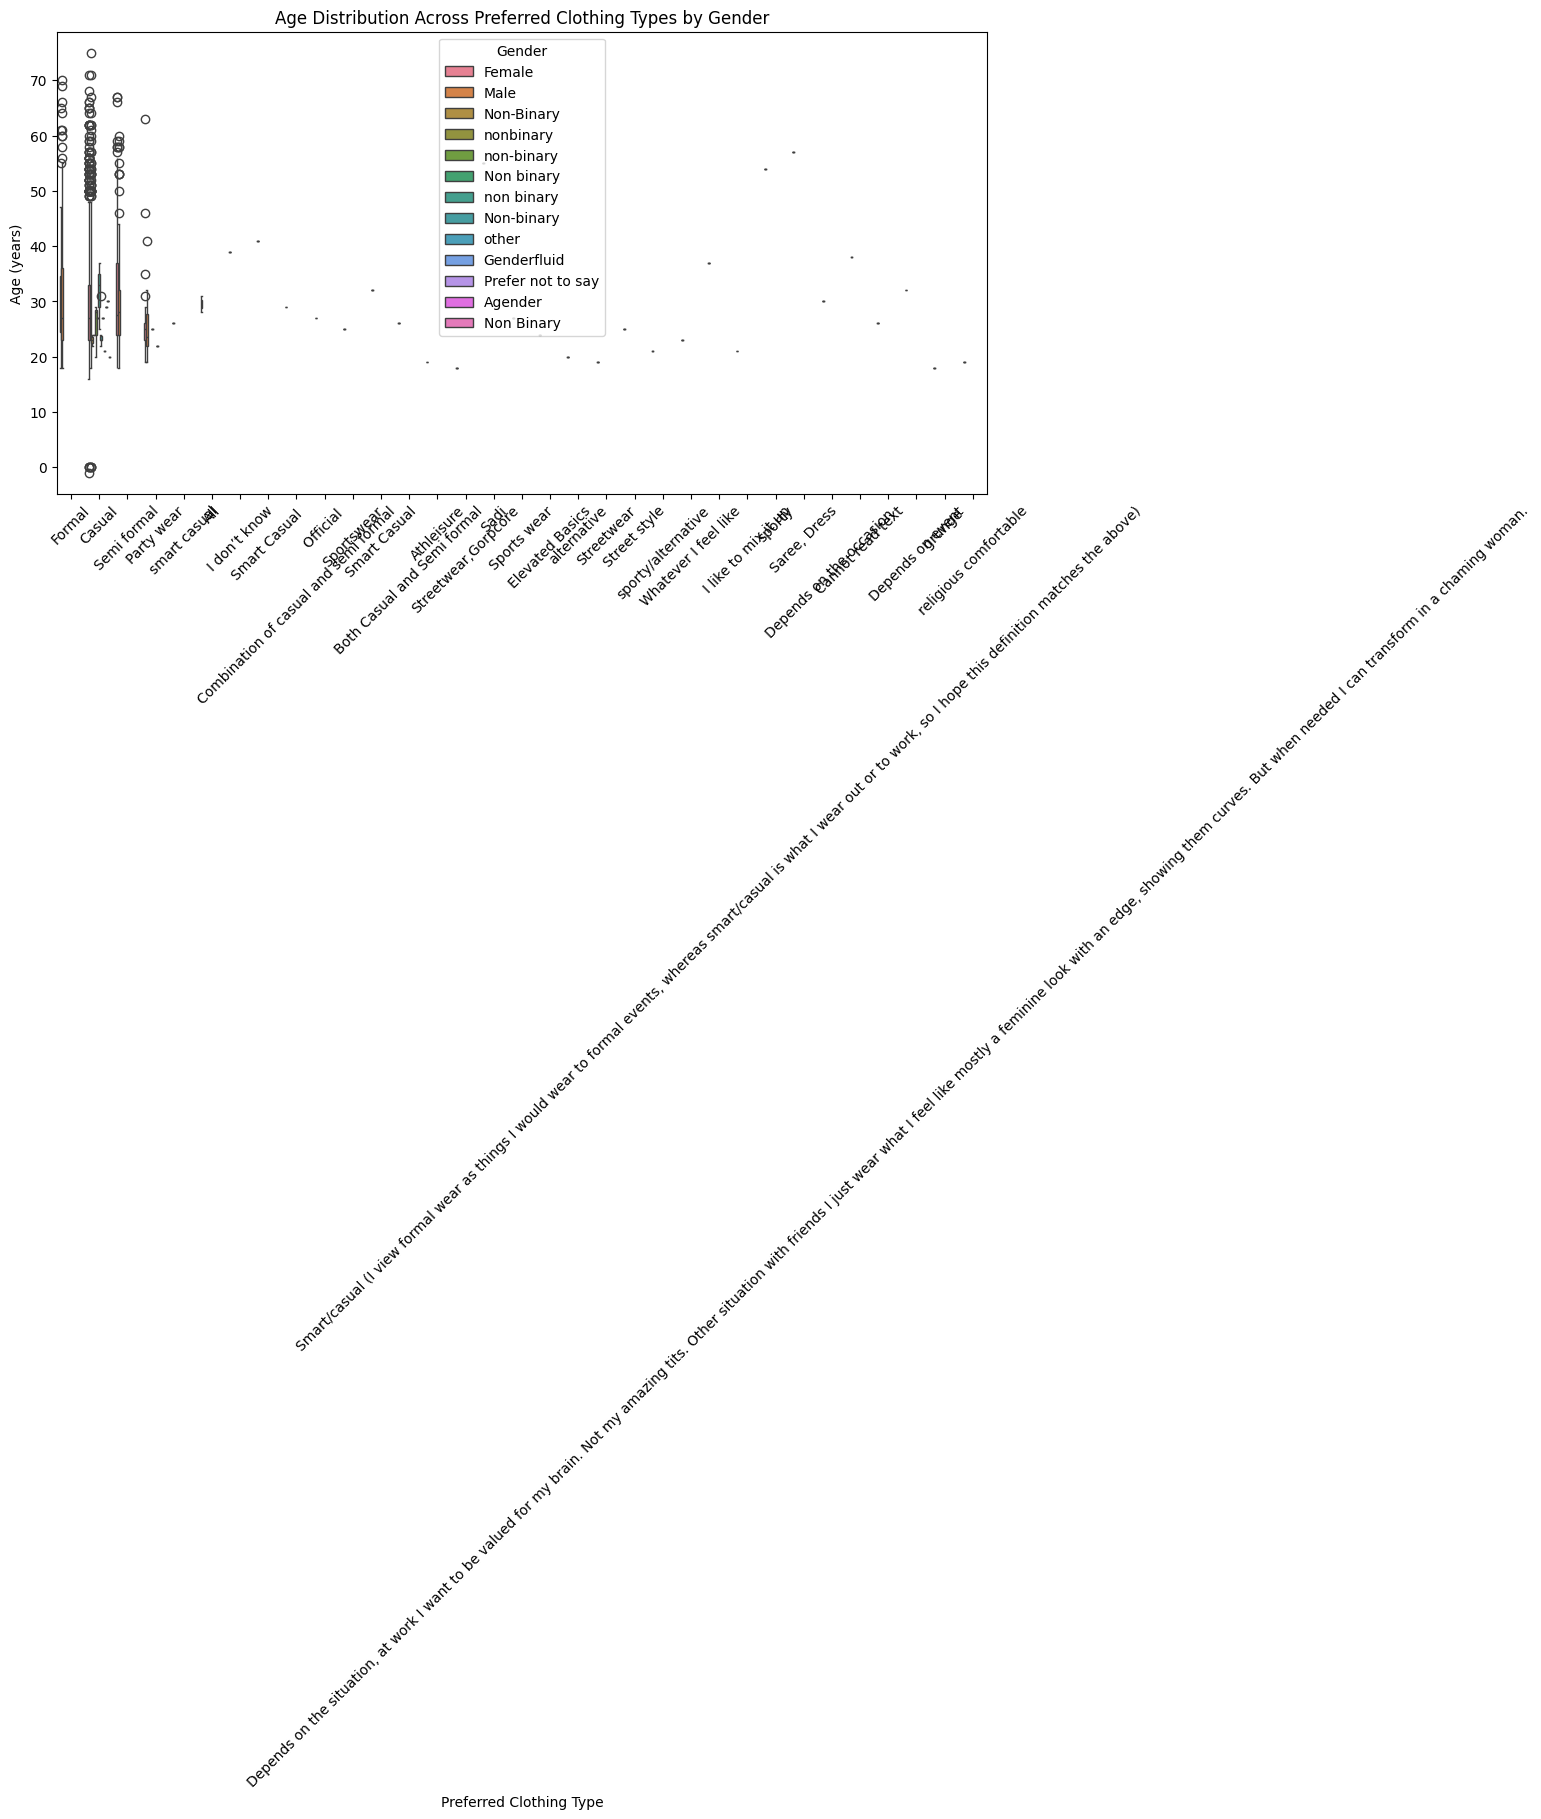

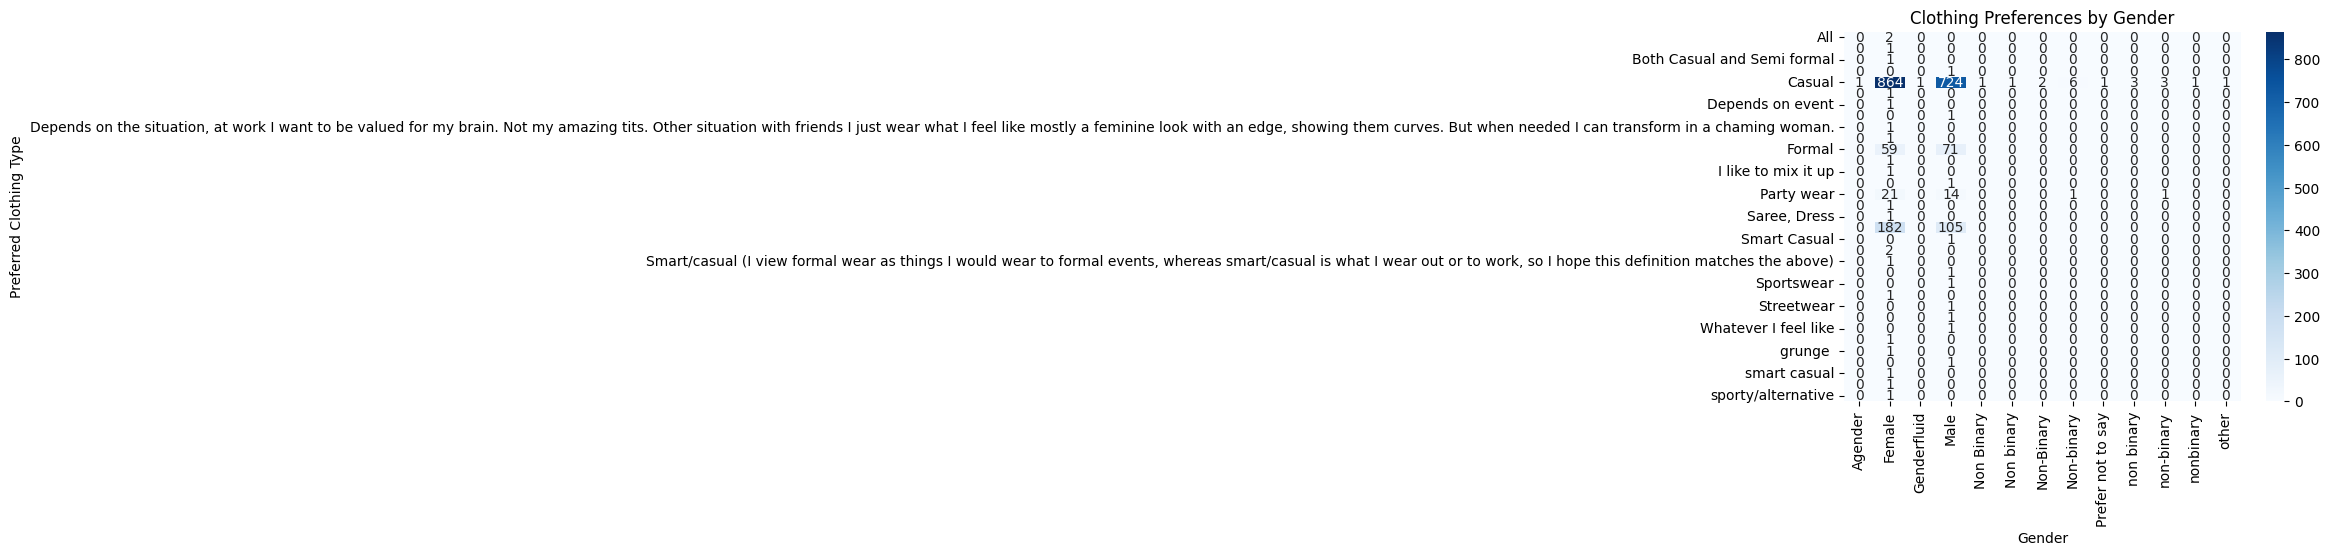

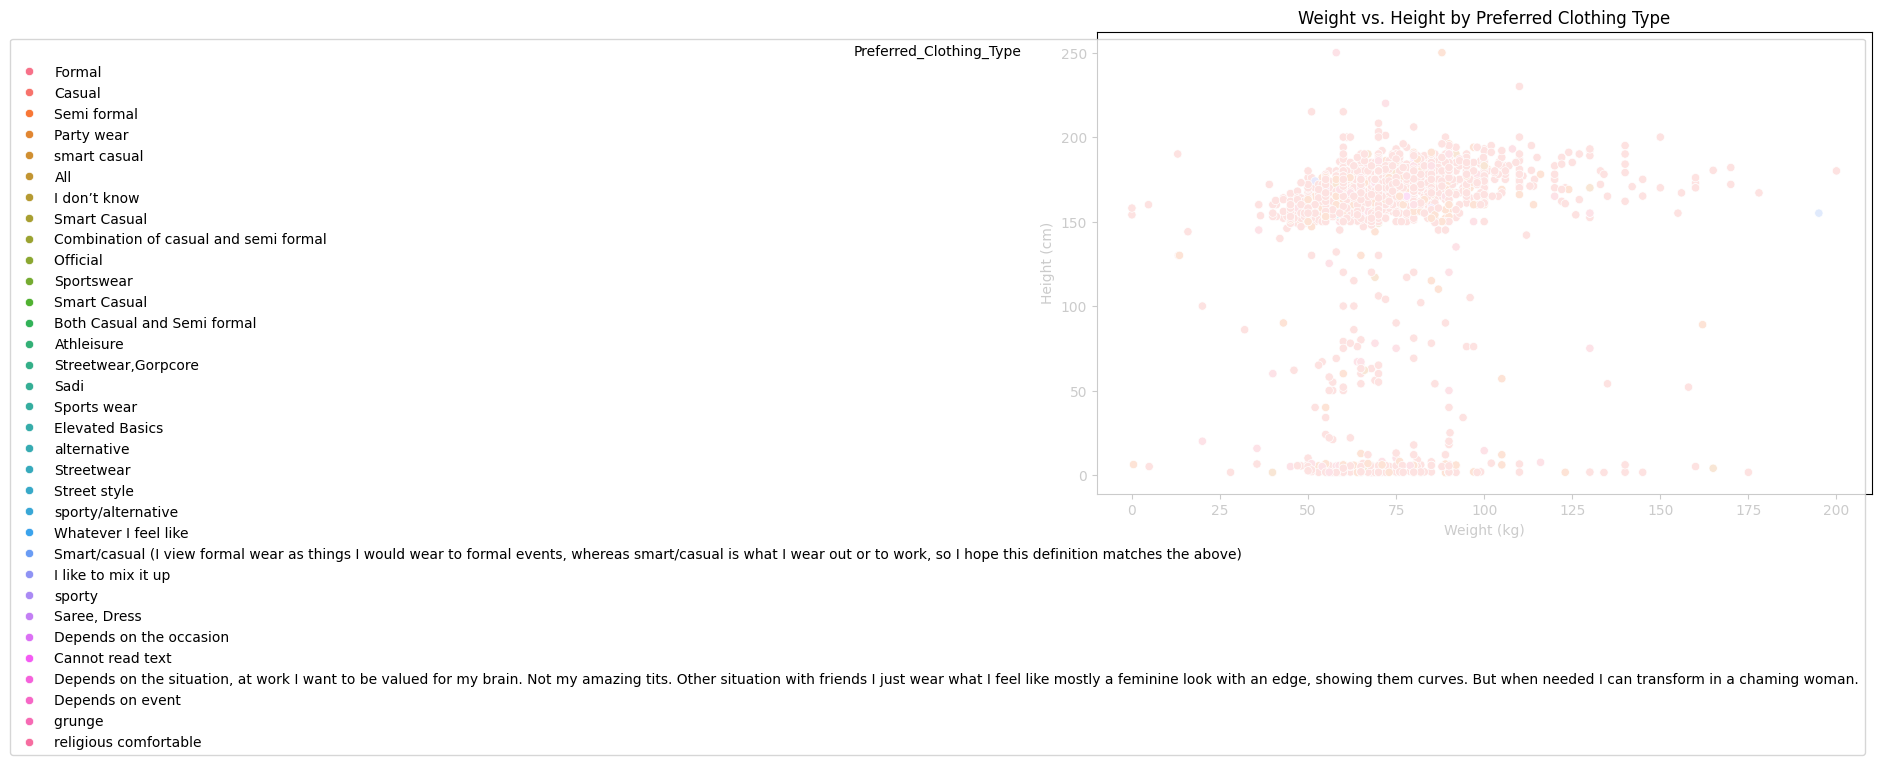

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
#df = pd.read_excel('dataset.xlsx')

# Convert 'Birthdate' to age
df['Birthdate'] = pd.to_datetime(df['Birthdate'], errors='coerce')
df['Age'] = (pd.Timestamp.now() - df['Birthdate']).dt.days // 365

# Ensure 'Weight_kg' and 'Height_cm' are numeric
df['Weight_kg'] = pd.to_numeric(df['Weight_kg'], errors='coerce')
df['Height_cm'] = pd.to_numeric(df['Height_cm'], errors='coerce')

# Drop rows with missing values crucial for analysis
df.dropna(subset=['Age', 'Weight_kg', 'Height_cm', 'Gender', 'Preferred_Clothing_Type'], inplace=True)

# Scatter Plot: Age vs. Weight by Preferred Clothing Type
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Weight_kg', hue='Preferred_Clothing_Type', style='Gender', data=df)
plt.title('Age vs. Weight by Preferred Clothing Type and Gender')
plt.xlabel('Age (years)')
plt.ylabel('Weight (kg)')
plt.legend(title='Clothing Type')
plt.show()

# Boxplot: Age Distribution by Preferred Clothing Type and Gender
plt.figure(figsize=(12, 6))
sns.boxplot(x='Preferred_Clothing_Type', y='Age', hue='Gender', data=df)
plt.title('Age Distribution Across Preferred Clothing Types by Gender')
plt.xlabel('Preferred Clothing Type')
plt.ylabel('Age (years)')
plt.xticks(rotation=45)
plt.show()

# Crosstab: Gender and Preferred Clothing Type
clothing_gender_crosstab = pd.crosstab(df['Preferred_Clothing_Type'], df['Gender'])
sns.heatmap(clothing_gender_crosstab, annot=True, cmap='Blues', fmt='d')
plt.title('Clothing Preferences by Gender')
plt.xlabel('Gender')
plt.ylabel('Preferred Clothing Type')
plt.show()

# Scatter Plot: Weight vs. Height by Preferred Clothing Type
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Weight_kg', y='Height_cm', hue='Preferred_Clothing_Type', data=df)
plt.title('Weight vs. Height by Preferred Clothing Type')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')
plt.show()


In [58]:
df.loc[df['Country_of_Residence'] == 'Same as Country of Birth', 'Country_of_Residence'] = df['Country_of_Birth']
df.loc[df['Color_Boost_Confidence'] == 'Yes', 'Best_Color_Confidence'] = df['Favourite_Color']

df.loc[df['Single_Piece_Preferred_Color'] == 'Yes', 'Single_Piece_Color'] = df['Color_Boost_Confidence']

df["Color_Boost_Confidence"].replace({"Yes":1, "No":0}, inplace=True)
df["Country_of_Birth"] = df["Country_of_Birth"].astype(str)
df["Country_of_Residence"] = df["Country_of_Residence"].astype(str)   
df["Country_of_Birth"] = df["Country_of_Birth"].str.strip().str.title()
df["Country_of_Residence"] = df["Country_of_Residence"].str.strip().str.title()

# Create a list of official country names
country_names = [country.name for country in pycountry.countries]
alpha_2_mapping = {country.alpha_2.title(): country.name.title() for country in pycountry.countries}

df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x: x.split(",")[-1] if isinstance(x, str) else x)
df["Country_of_Birth"] = df["Country_of_Birth"].str.title()
df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x:x.replace("The ", ""))
df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x:"Us" if x.find("America") != -1 else x)

df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x: x.split(",")[-1] if isinstance(x, str) else x)
df["Country_of_Residence"] = df["Country_of_Residence"].str.title()
df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x:x.replace("The ", ""))
df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x:"Us" if x.find("America") != -1 else x)

df["Country_of_Birth"] = df["Country_of_Birth"].replace({"Uk":"United Kingdom", 
                                "Usa": "United States",
                                "Us":"United States",
                                "America":"United States",
                                "United States Of America": "United States",
                                "United State Of America" : "United States",
                                "United States Of American":"United States",
                               "England": "United Kingdom",
                               "Wales":"United Kingdom",
                               "Scotland":"United Kingdom",
                               "Ksa": "Saudi Arabia",
                               "Rsa": "South Africa",
                               "Great Britain":"United Kingdom",
                               "Britain": "United Kingdom",
                               "Uae":"United Arab Emirates",
                               "United Kingdom Of Great Britain And Northern Ireland":"United Kingdom",
                            "Mumbai":"India",
                            "Czechia": "Czech Republic",
                            "Bharat":"India",
                            "Edinburgh":"United Kingdom",
                            "Korea":"South Korea",
                            "Russian Federation": "Russia",
                            "Thane":"India",
                            "Dubai": "United Arab Emirates",
                            "Democratic Republic Of Congo": "Congo",
                            "Europe":"United Kingdom",
                            "Italia":"Italy",
                            "Sssr" : "Russia"})

df["Country_of_Residence"] = df["Country_of_Residence"].replace({"Uk":"United Kingdom", 
                                "Usa": "United States",
                                "Us":"United States",
                                "America":"United States",
                                "United States Of America": "United States",
                                "United State Of America" : "United States",
                                "United States Of American":"United States",
                               "England": "United Kingdom",
                               "Wales":"United Kingdom",
                               "Scotland":"United Kingdom",
                               "Ksa": "Saudi Arabia",
                               "Rsa": "South Africa",
                               "Great Britain":"United Kingdom",
                               "Britain": "United Kingdom",
                               "Uae":"United Arab Emirates",
                               "United Kingdom Of Great Britain And Northern Ireland":"United Kingdom",
                            "Mumbai":"India",
                            "Czechia": "Czech Republic",
                            "Bharat":"India",
                            "Edinburgh":"United Kingdom",
                            "Korea":"South Korea",
                            "Russian Federation": "Russia",
                            "Thane":"India",
                            "Dubai": "United Arab Emirates",
                            "Democratic Republic Of Congo": "Congo",
                            "Europe":"United Kingdom",
                            "Italia":"Italy",
                            "Sssr" : "Russia"})

# Replace blank, NaN, or unreadable entries in 'Country_of_Birth' with 'Country_of_Residence'
df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x: np.nan if isinstance(x, str) and x.strip() in ['', 'Cannot Read Text'] else x)
df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x: np.nan if isinstance(x, str) and x.strip() in ['', 'Cannot Read Text'] else x)

df["Country_of_Birth"].fillna(df["Country_of_Residence"], inplace=True)
df["Country_of_Residence"].fillna(df["Country_of_Birth"], inplace=True)

# Get the unique values from the 'Country_of_Birth' column
unique_countries_1 = list(df['Country_of_Birth'].unique())
unique_countries_2 = list(df['Country_of_Residence'].unique())
unique_countries = np.union1d(unique_countries_1, unique_countries_2)

# Apply the function to the unique values
matched_countries = {country: get_best_match_with_confidence(country) for country in unique_countries}

# Create two new columns in the DataFrame by mapping the results back to the original 'Country_of_Birth' column
df['Country_of_Birth'] = df['Country_of_Birth'].apply(lambda x: matched_countries[x][0] if x in matched_countries else x)
#df['Match_Confidence'] = df['Country_of_Birth'].apply(lambda x: matched_countries[x][1] if x in matched_countries else 0)

df['Country_of_Residence'] = df['Country_of_Residence'].apply(lambda x: matched_countries[x][0] if x in matched_countries else x)

# Create a mapping from country names to numerical values
country_mapping = {country: idx + 1 for idx, country in enumerate(unique_countries)}

unique_countries_1 = list(df['Country_of_Birth'].unique())
unique_countries_2 = list(df['Country_of_Residence'].unique())
unique_countries = np.union1d(unique_countries_1, unique_countries_2)

country_map['name'] = country_map['name'].str.strip().str.lower().str.replace(' ', '', regex=True).str.replace(r"\s*\([^()]*\)", "", regex=True)

country_map = country_map.drop_duplicates(subset=['name'])

countries_normalized = np.char.replace(np.char.strip(np.char.lower(unique_countries)), ' ', '')

# Create a dictionary from the DataFrame for quick lookup
country_dict = dict(zip(country_map['name'], zip(country_map['latitude'], country_map['longitude'])))

# Map the countries in the array to their coordinates using the dictionary
coordinates = [country_dict.get(country, (None, None)) for country in countries_normalized]

# Convert to DataFrame for better visualization or further use
coordinates_df = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'], index=unique_countries).reset_index()

df = df.merge(coordinates_df, left_on='Country_of_Birth', right_on='index')
df.drop(columns=["index", "Country_of_Birth"], inplace=True)
# Rename latitude and longitude columns
df.rename(columns={'Latitude': 'birthplace_lat', 'Longitude': 'birthplace_lon'}, inplace=True)

df = df.merge(coordinates_df, left_on='Country_of_Residence', right_on='index')
df.drop(columns=["index", "Country_of_Residence"], inplace=True)

# Rename latitude and longitude columns
df.rename(columns={'Latitude': 'resi_lat', 'Longitude': 'resi_lon'}, inplace=True)
                                                              
df['resi_lat'].fillna(df['birthplace_lat'], inplace=True)
df['birthplace_lat'].fillna(df['resi_lat'], inplace=True)
df['resi_lon'].fillna(df['birthplace_lon'], inplace=True)
df['birthplace_lon'].fillna(df['resi_lon'], inplace=True)

df['Outer_Layer_Pattern'] = df['Outer_Layer_Pattern'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df['Single_Piece_Pattern'] = df['Single_Piece_Pattern'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df['Upperwear_Pattern'] = df['Upperwear_Pattern'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df = df.explode('Outer_Layer_Pattern')
df = df.explode('Single_Piece_Pattern')
df = df.explode('Upperwear_Pattern')

pattern_1 = list(df['Outer_Layer_Pattern'].unique())
pattern_2 = list(df['Single_Piece_Pattern'].unique())
pattern_3 = list(df['Upperwear_Pattern'].unique())
patterns = np.union1d(pattern_1, pattern_2)
patterns = np.union1d(patterns, pattern_3)
 
for pattern in patterns:
    i=pattern.lower()
    if pattern not in ['solid color', 'printed', 'stripes vertical','stripes horizontal', "tye die", "polka dots"]:
        if ("solid") in i or (i.startswith("pla")) or ("simple" in i):
            mapping_pattern[pattern] = "solid color"
        elif "print" in i:
            mapping_pattern[pattern] = "printed"
        elif "floral" in i or "flower" in i:
            mapping_pattern[pattern] = "floral printed"
        elif "graphic" in i or "logo" in i or "design" in i or "band" in i or "brand" in i:
            mapping_pattern[pattern] = "graphic printed"
        elif "che" in i or "box" in i or "block" in i or "cube" in i:
            mapping_pattern[pattern] = "box printed"
        elif "animal" in i:
            mapping_pattern[pattern] = "animal printed"
        elif "anime" in i:
            mapping_pattern[pattern] = "anime printed"  
        else:
            mapping_pattern[pattern] = "Not defined"
                    
#df['Outer_Layer_Pattern'] = df['Outer_Layer_Pattern'].replace(mapping_pattern)
df['Single_Piece_Pattern'] = df['Single_Piece_Pattern'].replace(mapping_pattern)
df['Upperwear_Pattern'] = df['Upperwear_Pattern'].replace(mapping_pattern)


df["Temp"] = df['Upperwear_Other_Details'].replace(mapping_pattern)
df["Upperwear_Pattern"] = df.apply(lambda x: x["Upperwear_Other_Details"] 
                              if x["Upperwear_Pattern"] == "Not defined"  else x["Upperwear_Pattern"],axis=1)
    
df["Temp"] = df['Clothing_Other_Details'].replace(mapping_pattern)
df["Single_Piece_Pattern"] = df.apply(lambda x: x["Clothing_Other_Details"]
                              if x["Single_Piece_Pattern"] == "Not defined"  else x["Single_Piece_Pattern"],axis=1)

df['Upperwear_Print_Type'] = df['Upperwear_Print_Type'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df['Outer_Layer_Print_Type'] = df['Outer_Layer_Print_Type'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df['Single_Piece_Print_Type'] = df['Single_Piece_Print_Type'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df = df.explode('Upperwear_Print_Type')
df = df.explode('Single_Piece_Print_Type')
df = df.explode('Outer_Layer_Print_Type')

pattern_1 = list(df['Upperwear_Print_Type'].unique())
pattern_2 = list(df['Single_Piece_Print_Type'].unique())
pattern_3 = list(df['Outer_Layer_Print_Type'].unique())
patterns = np.union1d(pattern_1, pattern_2)
patterns = np.union1d(patterns, pattern_3)

mapping_pattern = {}
for pattern in patterns:
    i=str(pattern).lower() 
    if "floral" in i or "flower" in i:
        mapping_pattern[pattern] = "floral printed"
    elif "graphic" in i or "logo" in i or "design" in i or "band" in i or "brand" in i or "image" in i or "mark" in i or "pictur" in i or "3d" in i or "art in i":
        mapping_pattern[pattern] = "graphic printed"
    elif "text" in i or "letter" in i or "sent" in i or "name" in i or "phrase" in i:
        mapping_pattern[pattern] = "text printed"
    elif "abstract" in i or "random" in i or "graffiti" in i:   
        mapping_pattern[pattern] = "abstract printed" 
    elif "geom" in i:   
        mapping_pattern[pattern] = "geometric printed"  
    elif "che" in i or "box" in i or "block" in i or "cube" in i:
        mapping_pattern[pattern] = "box printed"
    elif "anima" in i or "leopard" in i or "snake" in i or "cheeta" in i:
        mapping_pattern[pattern] = "animal printed"
    elif "cartoon" in i or "hero" in i or "face" in i or "game" in i:
        mapping_pattern[pattern] = "cartoon/game printed"
    elif "anime" in i:
        mapping_pattern[pattern] = "anime printed" 
    elif "print" in i:
        mapping_pattern[pattern] = "anything printed"
    else:
        mapping_pattern[pattern] = "Not defined printed"
        
df['Upperwear_Print_Type'] = df['Upperwear_Print_Type'].replace(mapping_pattern)
df['Outer_Layer_Print_Type'] = df['Outer_Layer_Print_Type'].replace(mapping_pattern)
df['Single_Piece_Print_Type'] = df['Single_Piece_Print_Type'].replace(mapping_pattern)

df["Temp"] = df['Upperwear_Other_Details'].replace(mapping_pattern)
df["Upperwear_Print_Type"] = df.apply(lambda x: x["Upperwear_Other_Details"]
                              if x["Upperwear_Print_Type"] == "anything printed" or  x["Upperwear_Print_Type"] == "Not defined printed"
                            else x["Upperwear_Print_Type"],axis=1)
    
df["Temp"] = df['Clothing_Other_Details'].replace(mapping_pattern)
df["Single_Piece_Print_Type"] = df.apply(lambda x: x["Clothing_Other_Details"]
                              if x["Single_Piece_Print_Type"] == "anything printed" or  x["Single_Piece_Print_Type"] == "Not defined printed"
                            else x["Single_Piece_Print_Type"],axis=1)

df.reset_index(inplace=True)
df.loc[df['Upperwear_Pattern'] == 'printed', 'Upperwear_Pattern'] = df['Upperwear_Print_Type']
df.loc[df['Outer_Layer_Pattern'] == 'printed', 'Outer_Layer_Pattern'] = df['Outer_Layer_Print_Type']
df.loc[df['Single_Piece_Pattern'] == 'printed', 'Single_Piece_Pattern'] = df['Single_Piece_Print_Type']
     
# Driver code 
df['Birthdate'] = pd.to_datetime(df['Birthdate'], errors='coerce')
df['Age'] = df['Birthdate'].apply(calculateAge)

df['Weight_kg'] = df['Weight_kg'].apply(lambda x: x * 100 if x < 1 else x)
df['Weight_kg'] = df['Weight_kg'].apply(lambda x: x * 10 if x < 10 else x)
df["Weight_kg"] = df["Weight_kg"].round(0)

df['Height_cm'] = df['Height_cm'].apply(lambda x: x * 100 if x < 2 else x)
df['Height_cm'] = df['Height_cm'].apply(lambda x: x * 30.48 if x < 15 else x)
df['Height_cm'] = df['Height_cm'].apply(lambda x: x * 2.54 if x < 100 else x)
df["Height_cm"] = df["Height_cm"].round(0)

# Normalize the sizes in the 'Size of clothes you wear' column
df['Clothing_Size'] = df['Clothing_Size'].apply(lambda sizes: ','.join([normalize_size_large(size) for size in sizes.split(',')]))
df['Clothing_Size'] = df['Clothing_Size'].apply(lambda sizes: ','.join([normalize_size_small(size) for size in sizes.split(',')]))
# Apply the function to the 'Size of clothes you wear' column
df['Clothing_Size'] = df['Clothing_Size'].apply(convert_size_to_numbers)

# Apply the function to the 'How do you define yourself' column
df['Personality'] = df['Personality'].apply(convert_personality_to_number)

df['Favourite_Color'] = df['Favourite_Color'].str.split(',')
df['Best_Color_Confidence'] = df['Best_Color_Confidence'].str.split(',')

df = df.explode('Favourite_Color')
df = df.explode("Clothing_Size")
df = df.explode("Best_Color_Confidence")

df["Favourite_Color"] = df["Favourite_Color"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x) if isinstance(x, str) else x)
df['Favourite_Color'] = df['Favourite_Color'].apply(custom_to_rgba)



Airoli
Czech Republic
D
Different
Dombivali West
Espaa
Indus
Iran
Ivory Coast
Marruecos
Polska
Russia
South Korea
Taiwan
Tanzania
Turkey
Turkey
Turkey
Us And Uk
Venezuela
nan


In [59]:
df["Best_Color_Confidence"] = df["Best_Color_Confidence"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
df['Best_Color_Confidence'] = df['Best_Color_Confidence'].apply(custom_to_rgba)

df = df.explode('Favourite_Color')
df = df.explode("Best_Color_Confidence")


df['Gender'] = df['Gender'].apply(lambda x: 1 if x.lower() == 'male' else (3 if x.lower() == 'female' else 2))

df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(lambda x:str(x).lower().strip())
# Apply the function to a specific column, e.g., 'Preferred_Clothing_Type'
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(remove_bracketed_text)
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(lambda x:x.replace("both", "").replace("combination", "").replace("smart", ""))
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].str.split('and')
df = df.explode("Preferred_Clothing_Type")
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].str.split('/')
df = df.explode("Preferred_Clothing_Type")
# Apply the function to a specific column, e.g., 'How do you define yourself'
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(remove_stop_words)
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(lambda x:x.replace(" ", ""))
# Apply the function to the cleaned column
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(replace_clothing_type)
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].str.split(',')
df = df.explode('Preferred_Clothing_Type')

#Create a mapping from clothing types to numerical values
clothing_type_mapping = {clothing_type: idx + 1 for idx, clothing_type in enumerate(allowed_types)}

# Save the mapping dictionary to a JSON file
with open('Preferred_Clothing_Type.json', 'w') as f:
    json.dump(clothing_type_mapping, f)

# Apply the function to the final cleaned column
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].map(clothing_type_mapping)

# Apply the mapping to convert the 'Preferred_clothing' column to numerical values
df['Preferred_Clothing'] = df['Preferred_Clothing'].map(preferred_clothing_mapping)

# Apply the function to each column in the list
for column in columns_to_process:
    df = handle_output_columns(df, column)
    
#df["test"] = df.apply(lambda x: custom_to_rgba(x["Upperwear_Other_Details"]) if x["Favourite_Color"] == [[-1, -1, -1, 1]] else x["Favourite_Color"],axis=1)

df = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Personality', 'Clothing_Size',
        'Preferred_Clothing','Favourite_Color', 'Best_Color_Confidence', 'Preferred_Bottoms', 
        'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color', 'Preferred_Upperwear', 'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline', 
        'Upperwear_Sleeve_Type', 'Upperwear_Pattern', 'Upperwear_Color',
         'Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length', 
         'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern','Single_Piece_Color' , 'birthplace_lat','birthplace_lon', 'resi_lat', 
         'resi_lon', 'Age']]

df.drop_duplicates(inplace=True)
df.fillna(0, inplace=True)

Bottoms_Color
Upperwear_Color
Single_Piece_Color


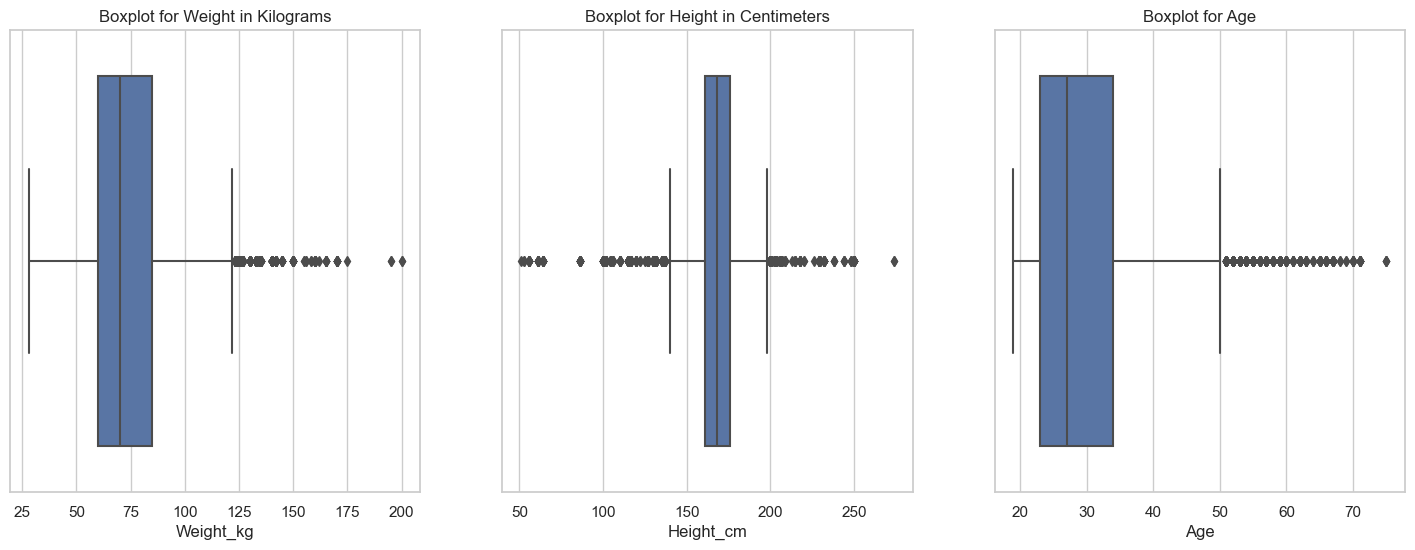

In [8]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating a figure to hold the boxplots
plt.figure(figsize=(18, 6))  # Wider figure to accommodate three subplots

# Subplot for Weight in Kilograms
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.boxplot(x=df['Weight_kg'])
plt.title('Boxplot for Weight in Kilograms')

# Subplot for Height in Centimeters
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.boxplot(x=df['Height_cm'])
plt.title('Boxplot for Height in Centimeters')

# Subplot for Age
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.boxplot(x=df['Age'])
plt.title('Boxplot for Age')

# Save the figure
plt.savefig('outliers.png', format='png', dpi=300)  # Save as PNG with high resolution

# Display the plots
plt.show()

df = df[df["Height_cm"] < 300]
df = df[df["Height_cm"] > 50]
df = df[df["Weight_kg"] > 25]
df = df[df["Age"] > 18]

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating a figure to hold the boxplots
plt.figure(figsize=(18, 6))  # Wider figure to accommodate three subplots

# Subplot for Weight in Kilograms
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.boxplot(x=df['Weight_kg'])
plt.title('Boxplot for Weight in Kilograms')

# Subplot for Height in Centimeters
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.boxplot(x=df['Height_cm'])
plt.title('Boxplot for Height in Centimeters')

# Subplot for Age
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.boxplot(x=df['Age'])
plt.title('Boxplot for Age')

# Save the figure
plt.savefig('removed_outliers.png', format='png', dpi=300)  # Save as PNG with high resolution

# Display the plots
plt.show()

In [9]:
df.to_excel("preprocessed_data.xlsx", index=False)